# 02_Classification

> Last Update: 06/13/2020 <br>
Author: [Gunsu Altindag](https://www.linkedin.com/in/gunsualtindag) | [Yalim Demirkesen](https://www.linkedin.com/in/yalimdemirkesen/)

**Description**

After the preprocessing is completed, we have the dataset that we will train/test our classification model. After the testing is completed, I have an additional dataset for all the combinations of location, industry, part of the day, day of the week and amount spent. The model will be used to predict how many conversions we will have as a result of the campaigns.

In [268]:
# necessary libraries:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
import pandas as pd
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# display settings
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

# modelling libraries:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

## Uploading and Preparing the Data

In [290]:
fb = pd.read_csv("./data/fb.csv")

In [291]:
df_sept = pd.read_csv("./data/testdata_sep.csv")

In [292]:
fb.shape

(23384, 28)

In [293]:
fb.drop(columns=['Unnamed: 0'], inplace=True)
df_sept.drop(columns=['Unnamed: 0'], inplace=True)

I will exclude the month of September from the training and testing data. After I test the data, I will go on and make the predictions and optimization and compare it with the actual results in September. 

In [294]:
fb[(fb['2019']==1) & (fb['month']==9)].to_csv('./data/actual_sep.csv')

In [295]:
fb = fb[~((fb['2019']==1) & (fb['month']==9))].reset_index(drop=True)

In [296]:
fb.head()

,month,week_num,afternoon,evening,morning,night,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Mon,Tues,Weds,Thurs,Fri,Sat,Sun,2018,2019,amount_spent_usd,labels
0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,17.052800,btw 1 and 2 conversions
1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,23.137473,btw 1 and 2 conversions
2,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,3.204700,0 conversions
3,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,39.000829,0 conversions
4,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,11.831640,0 conversions


In [297]:
df_sept.head()

,month,week_num,afternoon,evening,morning,night,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,Fri,Mon,Sat,Sun,Thurs,Tues,Weds,2018,2019,amount_spent_usd
0,9,35,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
1,9,35,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
2,9,35,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,9,35,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,9,35,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [97]:
# creating the predictor and target datasets:
X = fb[['month','week_num','DE','ES','FR','IT','MX','UK','US','ZA','OR','SSF','night','morning','afternoon','evening',
        'Mon','Tues','Weds','Thurs','Fri','Sat','Sun','2018','2019','amount_spent_usd']]
y = fb['labels']

In [98]:
X_sep = df_sept[['month','week_num','DE','ES','FR','IT','MX','UK','US','ZA','OR','SSF','night','morning','afternoon','evening',
        'Mon','Tues','Weds','Thurs','Fri','Sat','Sun','2018','2019','amount_spent_usd']]

In [99]:
# splitting the data into training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25,random_state=44)

Checking the shape of each new dataset. I expect training and testing datasets to have same length. All datasets need to have same number of predictors.

In [100]:
X_train.shape

(16676, 26)

In [101]:
y_train.shape

(16676,)

In [102]:
y_test.shape

(5559,)

In [103]:
X_test.shape

(5559, 26)

In [104]:
X_sep.shape

(337920, 26)

In [105]:
y_train.value_counts()

0 conversions              6528
btw 1 and 2 conversions    5338
btw 3 and 5 conversions    2726
more than 5 conversions    2084
Name: labels, dtype: int64

Scaling for the amount spent column throughout all the datasets:

In [106]:
scaler = StandardScaler()

In [107]:
X_train['amount_spent_usd'] = scaler.fit_transform(X_train.amount_spent_usd.values.reshape(-1, 1))

In [108]:
X_train.amount_spent_usd.describe()

count    1.667600e+04
mean     2.014393e-16
std      1.000030e+00
min     -5.598794e-01
25%     -4.632067e-01
50%     -3.437911e-01
75%     -4.851158e-03
max      1.877850e+01
Name: amount_spent_usd, dtype: float64

In [109]:
X_test['amount_spent_usd'] = scaler.fit_transform(X_test.amount_spent_usd.values.reshape(-1, 1))

In [110]:
X_test.amount_spent_usd.describe()

count    5.559000e+03
mean     1.773481e-16
std      1.000090e+00
min     -5.849667e-01
25%     -4.850203e-01
50%     -3.609831e-01
75%     -7.979976e-04
max      1.884786e+01
Name: amount_spent_usd, dtype: float64

In [111]:
X_sep['amount_spent_usd'] = scaler.fit_transform(X_sep.amount_spent_usd.values.reshape(-1, 1))

In [112]:
X_sep.amount_spent_usd.describe()

count    3.379200e+05
mean    -1.135324e-17
std      1.000001e+00
min     -1.722237e+00
25%     -8.611187e-01
50%      0.000000e+00
75%      8.611187e-01
max      1.722237e+00
Name: amount_spent_usd, dtype: float64

## Modelling

In the modelling phase, the road map is to create an ensemble model including different classification models. At the end the models will have a weight as much as their accuracy. The weights will be summed and the class with the most votes will be accepted as the final prediction.

Let's say, each algorithm's predictions for the level of conversion if we spend $50 for 09/03/2019 evening (in the time zone of the host account) for users in Germany who are in OR industry:
- Algorithm 1 predicts for each class: 0.23 | 0.07 | 0.63 | 0.07
- Algorithm 2 predicts for each class: 0.21 | 0.02 | 0.57 | 0.20
- Algorithm 3 predicts for each class: 0.27 | 0.05 | 0.66 | 0.02
- Algorithm 4 predicts for each class: 0.15 | 0.04 | 0.59 | 0.22
- Algorithm 5 predicts for each class: 0.19 | 0.06 | 0.33 | 0.42

Then the conversions between 3 and 5 wins since its average probability is higher than any other class.

### Logistic Regression

In logistic regression, we will use softmax instead of sigmoid function which is the default case. The reason is we are working with multiclass problem. While initiating the model, there will be different hyperparameters that we need to work with which are listed below:
- `multiclass`: this will be `multinomial` since we are dealing with a multiclass problem.
- `solver`: there are plenty solvers that we can use for this use case which are `newton-cg`, `sag`, `saga` and `lbfgs`.
    - Newton's Method uses a quadratic approximation. In each step we are getting closer to the global optima. It is expensive to deploy and also has problems with minimax (saddle) points. 
    <img src="https://i.stack.imgur.com/VqQnf.png" >
    - Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm is very similar to Newton's but it stores that represent the approximation. lbfgs is very memory efficient but have some drawbacks like converging to any value. No global optima is guarenteed.
    - Stochastic Average Gradient holds a memory of previous gradient values and using this technique it converges faster. Storing older iterations makes it more precise but slower.
    - SAGA is a version of Stochastic Average Gradient that supports L1 regularization which eliminates the non-contributing predictors. That's why its best use is with large datasets.
- `penalty`: most of the solvers need `l2` but with saga we can also use `l1` but we don't need to utilize that since out dataset is not huge in terms of predictors.
- `tol`: stands for tolerance. This is the level for scikit-learn to understand when to stop for optimizing the objective function of the model.
- `C`: smaller C gets, stronger regularization becomes. 
- `max_iter`: just like tol, max_iter provides a limit for the model to stop looking for additional improvement.

**[Source: scikit-learn logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**

In [113]:
softmax_params = {
    'C':[12,13,14,15],
    'max_iter':[10000,100000]
    
}

softmax_grid = GridSearchCV(
                    LogisticRegression(multi_class='multinomial', 
                                       solver='lbfgs',
                                       penalty='l2',
                                       tol=1e-16, 
                                      ),
                    softmax_params,
                    cv = 5,
                    verbose = 1,
                    return_train_score = True
)

In [115]:
# fit the data:
softmax_reg=softmax_grid.fit(X_train,y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.6min finished


In [118]:
label=np.unique(y_train)

In [119]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

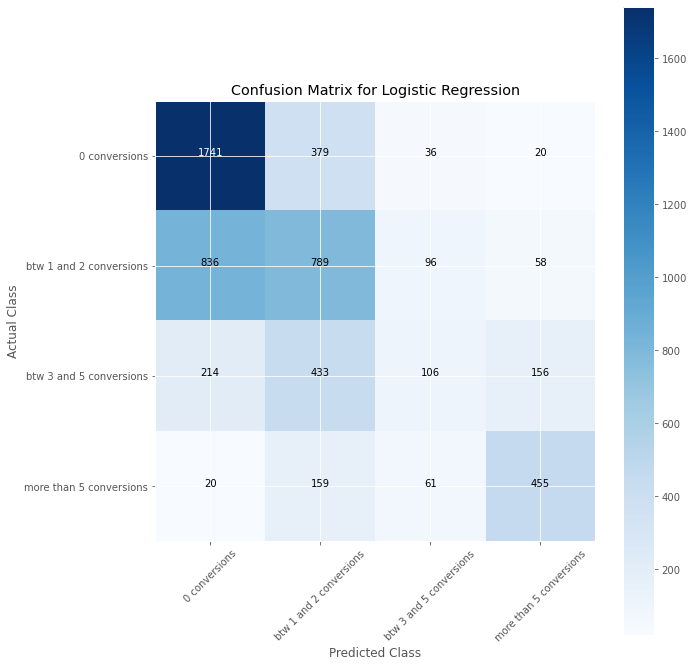

In [120]:
cnf_matrix = confusion_matrix(y_test, y_pred_softmax,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for Logistic Regression')

In [121]:
print("Accuracy of the training set: {}".format(round(accuracy_score(y_train,softmax_grid.predict(X_train)),4)))
print("Accuracy of the training set: {}".format(round(accuracy_score(y_test,softmax_grid.predict(X_test)),4)))

Accuracy of the training set: 0.5504
Accuracy of the training set: 0.556


In [155]:
# generate the predictions:
y_pred_softmax = softmax_grid.predict(X_test)  
y_pred_sep_softmax = softmax_grid.predict(X_sep)

# calculate the probabilities:
y_prob_softmax = softmax_grid.predict_proba(X_test)
y_prob_sep_softmax = softmax_grid.predict_proba(X_sep)

As expected the accuracy of the Logistic Regression model is not that high. After all it is a better model to use when we have a binary classification problem. Next model I will use it Random Forest. Now I am expecting a higher performance since we will be using an ensemble model that takes into account the "forest" instead of the single "trees".

### Random Forest

Random forest hyperparameters:
- `n_estimators`: number of trees
- `criterion`: `gini` or `entropy`
- `max_depth`: max depth for the trees
- `min_sample_split`: minimum number of samples needed to split the nodes:
- `max_features`: number of features to consider while splitting
    - `auto` for square root of number of features.
    - `None` for taking into account all the features.
    - if int, then take that many features.
- `class_weight`: Described like the following in the sklearn webpage:
>*Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.*
    *Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be `[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}]` instead of `[{1:1}, {2:5}, {3:1}, {4:1}]`.
    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`. 
    The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.*

**[Source: scikit-learn random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)**

In [143]:
rfc = RandomForestClassifier(n_estimators = 50, max_leaf_nodes = 16 ,
                             n_jobs =-1, random_state=42)

param_grid = {
    'min_samples_split': [5, 7], 
    'n_estimators' : [400,500,600],
    'max_depth': [25,27,30],
    'max_features': [20,22]
}

scorers = {
    'precision_score': make_scorer(precision_score,average='micro'),
    'recall_score': make_scorer(recall_score,average='micro')
}

In [150]:
# fits a GridSearchCV classifier using refit_score for optimization
refit_score='precision_score'

# prints classifier performance metrics
skf = StratifiedKFold(n_splits=10)
rfc_grid = GridSearchCV(rfc, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)


In [151]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(max_leaf_nodes=16,
                                              n_estimators=50, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [25, 27, 30], 'max_features': [20, 22],
                         'min_samples_split': [5, 7],
                         'n_estimators': [400, 500, 600]},
             refit='precision_score', return_train_score=True,
             scoring={'precision_score': make_scorer(precision_score, average=micro),
                      'recall_score': make_scorer(recall_score, average=micro)})

In [153]:
print('Best parameters for {}:'.format(refit_score))
print(rfc_grid.best_params_)
print('Best score for {}:'.format(refit_score))
print(rfc_grid.best_score_)

Best parameters for precision_score:
{'max_depth': 25, 'max_features': 22, 'min_samples_split': 5, 'n_estimators': 500}
Best score for precision_score:
0.5587675630341558


In [154]:
# Build the model after having the hyperparameters that creates the highest performance:

# Using entropy during the split:
clf_rf_enpy = RandomForestClassifier(criterion='entropy',max_depth=25, 
                                 max_features=22,min_samples_split=5, 
                                 n_estimators=500).fit(X_train, y_train)

# Using gini during the split:
clf_rf_gini = RandomForestClassifier(criterion='gini',max_depth=25, 
                                 max_features=22,min_samples_split=5, 
                                 n_estimators=500).fit(X_train, y_train)

In [156]:
# make the predictions for rf with entropy
y_pred_enpy = clf_rf_enpy.predict(X_test)
y_pred_sep_enpy = clf_rf_enpy.predict(X_sep)

# calculate the probabilities for rf with entropy
y_prob_enpy = clf_rf_enpy.predict_proba(X_test)
y_prob_sep_enpy = clf_rf_enpy.predict_proba(X_sep)

# make the predictions for rf with gini
y_pred_gini = clf_rf_gini.predict(X_test)
y_pred_sep_gini = clf_rf_gini.predict(X_sep)

# calculate the probabilities for rf with gini
y_prob_gini = clf_rf_gini.predict_proba(X_test)
y_prob_sep_gini = clf_rf_gini.predict_proba(X_sep)

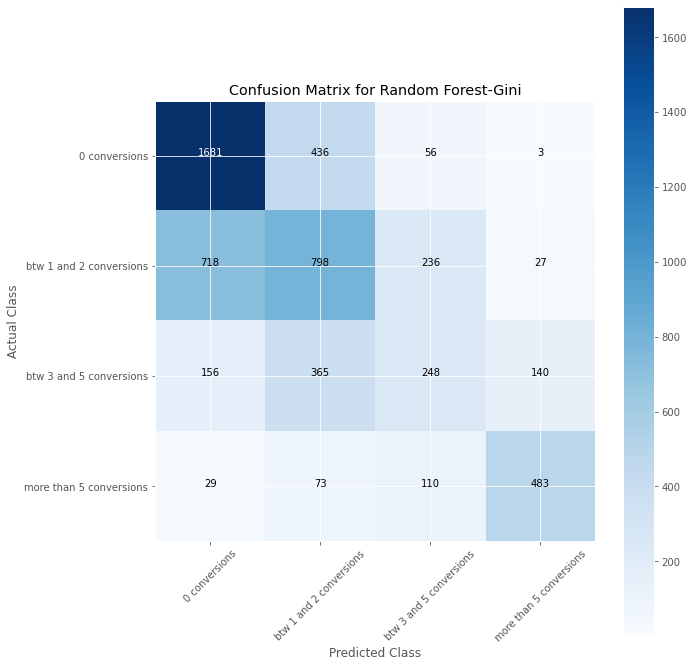

In [157]:
cnf_matrix = confusion_matrix(y_test, y_pred_gini,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for Random Forest-Gini')

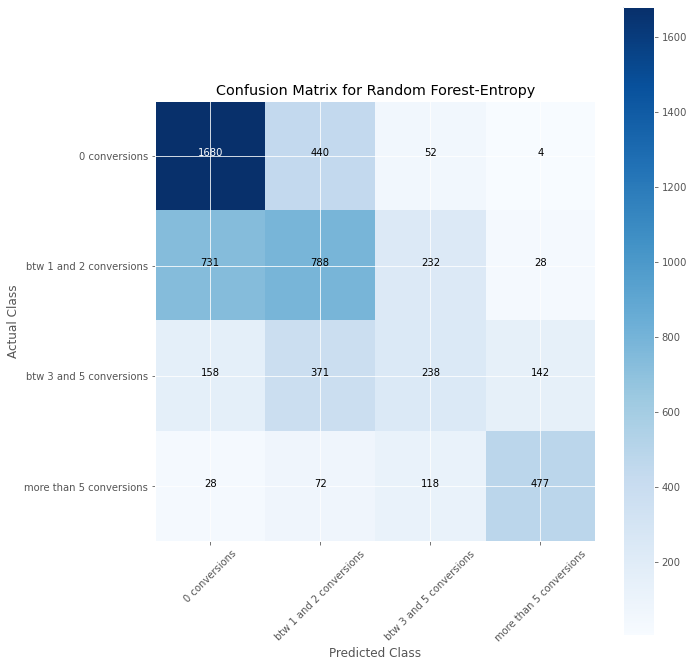

In [158]:
cnf_matrix = confusion_matrix(y_test, y_pred_enpy,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for Random Forest-Entropy')

Since at the end I will build a voting ensemble, we need a dataframe with probabilities and predictions for each observation with probabilities for each algorithm. 

In [162]:
y_test_df=pd.DataFrame(y_test)
y_test_sep_df=pd.DataFrame(None)

In [163]:
y_test.head()

7890     more than 5 conversions
21440              0 conversions
5536     btw 1 and 2 conversions
14287    more than 5 conversions
12994              0 conversions
Name: labels, dtype: object

In [164]:
# For logistic regression:
y_test_df['pred_softmax'] = y_pred_softmax
y_test_df['prob_softmax']= np.round(np.array(y_prob_softmax),2).tolist()

y_test_sep_df['pred_softmax'] = y_pred_sep_softmax
y_test_sep_df['prob_softmax'] = np.round(np.array(y_prob_sep_softmax),2).tolist()

# For Random Forest with Gini:
y_test_df['pred_rf_gini'] = y_pred_gini
y_test_df['prob_rf_gini']= np.round(np.array(y_prob_gini),2).tolist()

y_test_sep_df['pred_rf_gini'] = y_pred_sep_gini
y_test_sep_df['prob_rf_gini'] = np.round(np.array(y_prob_sep_gini),2).tolist()

# For Random Forest with Entropy:
y_test_df['pred_rf_enpy'] = y_pred_enpy
y_test_df['prob_rf_enpy']= np.round(np.array(y_prob_enpy),2).tolist()

y_test_sep_df['pred_rf_enpy'] = y_pred_sep_enpy
y_test_sep_df['prob_rf_enpy'] = np.round(np.array(y_prob_sep_enpy),2).tolist()

In [165]:
y_test_df.head(2)

,labels,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy
7890,more than 5 conversions,more than 5 conversions,"[0.0, 0.11, 0.32, 0.56]",more than 5 conversions,"[0.02, 0.04, 0.4, 0.54]",more than 5 conversions,"[0.02, 0.03, 0.41, 0.54]"
21440,0 conversions,0 conversions,"[0.79, 0.18, 0.03, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.93, 0.07, 0.0, 0.0]"


In [166]:
y_test_sep_df.head(2)

,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy
0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]"
1,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]"


### kNN

In [191]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [15,21,27]
}

scorers = {
    'precision_score': make_scorer(precision_score,average='micro'),
    'recall_score': make_scorer(recall_score,average='micro'),
    'accuracy_score': make_scorer(accuracy_score)
}

In [192]:
# fits a GridSearchCV classifier using refit_score for optimization
refit_score='accuracy_score'

# prints classifier performance metrics
skf = StratifiedKFold(n_splits=10)
knn_grid = GridSearchCV(knn, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True)


In [193]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [15, 21, 27]}, refit='accuracy_score',
             return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score, average=micro),
                      'recall_score': make_scorer(recall_score, average=micro)})

In [194]:
print('Best parameters for {}:'.format(refit_score))
print(knn_grid.best_params_)
print('Best score for {}:'.format(refit_score))
print(knn_grid.best_score_)

Best parameters for accuracy_score:
{'n_neighbors': 21}
Best score for accuracy_score:
0.5711193372836225


In [195]:
# Build the model after having the hyperparameters that creates the highest performance:
clf_knn = KNeighborsClassifier(n_neighbors=21).fit(X_train, y_train)

In [196]:
# make the predictions 
y_pred_knn = clf_knn.predict(X_test)
y_pred_sep_knn = clf_knn.predict(X_sep)

# calculate the probabilities 
y_prob_knn = clf_knn.predict_proba(X_test)
y_prob_sep_knn = clf_knn.predict_proba(X_sep)

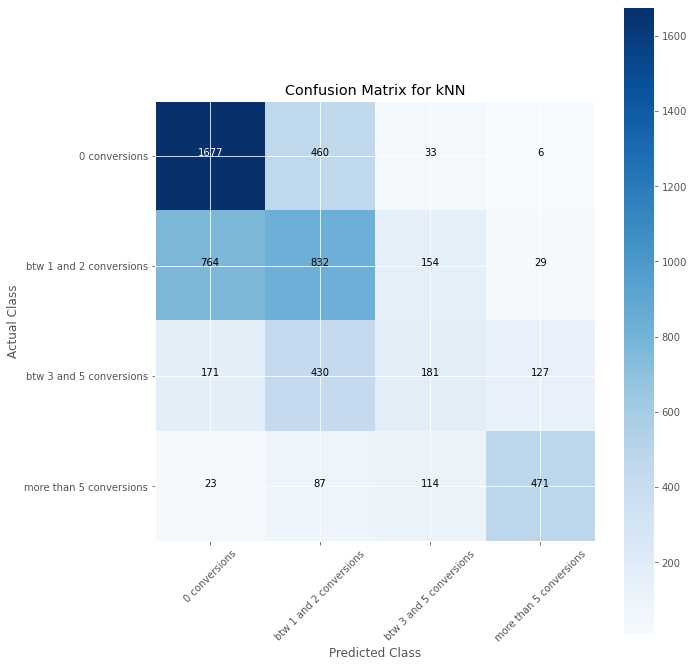

In [197]:
cnf_matrix = confusion_matrix(y_test, y_pred_knn,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for kNN')

In [198]:
# Expending the dataframe with kNN:
y_test_df['pred_knn'] = y_pred_knn
y_test_df['prob_knn']= np.round(np.array(y_prob_knn),2).tolist()

y_test_sep_df['pred_knn'] = y_pred_sep_knn
y_test_sep_df['prob_knn'] = np.round(np.array(y_prob_sep_knn),2).tolist()

In [199]:
y_test_df.head(2)

,labels,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn
7890,more than 5 conversions,more than 5 conversions,"[0.0, 0.11, 0.32, 0.56]",more than 5 conversions,"[0.02, 0.04, 0.4, 0.54]",more than 5 conversions,"[0.02, 0.03, 0.41, 0.54]",more than 5 conversions,"[0.05, 0.1, 0.29, 0.57]"
21440,0 conversions,0 conversions,"[0.79, 0.18, 0.03, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.93, 0.07, 0.0, 0.0]",0 conversions,"[0.86, 0.05, 0.1, 0.0]"


In [200]:
y_test_sep_df.head(2)

,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn
0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.57, 0.38, 0.0, 0.05]"
1,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]"


### Support Vector Machine

In [211]:
svm = SVC(decision_function_shape='ovo', # for multiclass
          random_state = 42,
          kernel='rbf')

param_grid = {
    'gamma': [0.01,0.05,0.1]
}

scorers = {
    'precision_score': make_scorer(precision_score,average='micro'),
    'recall_score': make_scorer(recall_score,average='micro'),
    'accuracy_score': make_scorer(accuracy_score)
}

In [212]:
# fits a GridSearchCV classifier using refit_score for optimization
refit_score='precision_score'

# prints classifier performance metrics
skf = StratifiedKFold(n_splits=10)
svm_grid = GridSearchCV(svm, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True)


In [213]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(decision_function_shape='ovo', random_state=42),
             param_grid={'gamma': [0.01, 0.05, 0.1]}, refit='precision_score',
             return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score, average=micro),
                      'recall_score': make_scorer(recall_score, average=micro)})

In [214]:
print('Best parameters for {}:'.format(refit_score))
print(svm_grid.best_params_)
print('Best score for {}:'.format(refit_score))
print(svm_grid.best_score_)

Best parameters for precision_score:
{'gamma': 0.1}
Best score for precision_score:
0.5817331857369533


In [217]:
# Build the model after having the hyperparameters that creates the highest performance:
clf_svm = SVC(random_state=42,
              kernel='rbf', 
              decision_function_shape='ovo',
              gamma = 0.1, probability=True).fit(X_train, y_train)

In [218]:
# make the predictions 
y_pred_svm = clf_svm.predict(X_test)
y_pred_sep_svm = clf_svm.predict(X_sep)

# calculate the probabilities
y_prob_svm = clf_svm.predict_proba(X_test,)
y_prob_sep_svm = clf_svm.predict_proba(X_sep)

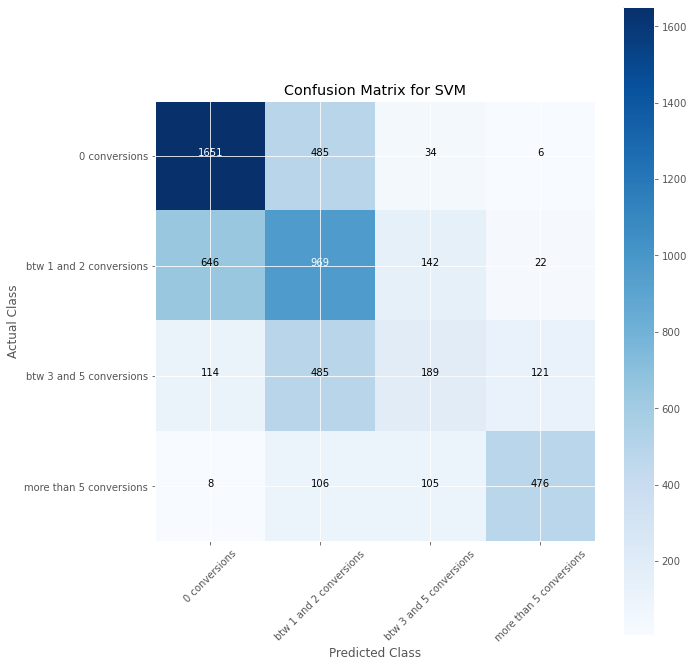

In [219]:
cnf_matrix = confusion_matrix(y_test, y_pred_svm,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for SVM')

In [220]:
# Expending the dataframe with kNN:
y_test_df['pred_svm'] = y_pred_svm
y_test_df['prob_svm']= np.round(np.array(y_prob_svm),2).tolist()

y_test_sep_df['pred_svm'] = y_pred_sep_svm
y_test_sep_df['prob_svm'] = np.round(np.array(y_prob_sep_svm),2).tolist()

In [221]:
y_test_df.head(2)

,labels,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm
7890,more than 5 conversions,more than 5 conversions,"[0.0, 0.11, 0.32, 0.56]",more than 5 conversions,"[0.02, 0.04, 0.4, 0.54]",more than 5 conversions,"[0.02, 0.03, 0.41, 0.54]",more than 5 conversions,"[0.05, 0.1, 0.29, 0.57]",more than 5 conversions,"[0.01, 0.03, 0.18, 0.79]"
21440,0 conversions,0 conversions,"[0.79, 0.18, 0.03, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.93, 0.07, 0.0, 0.0]",0 conversions,"[0.86, 0.05, 0.1, 0.0]",0 conversions,"[0.78, 0.15, 0.06, 0.01]"


In [222]:
y_test_sep_df.head(2)

,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm
0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.57, 0.38, 0.0, 0.05]",0 conversions,"[0.78, 0.18, 0.02, 0.01]"
1,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.84, 0.14, 0.01, 0.01]"


### XGBoost

In [234]:
xgb = XGBClassifier()

param_grid = {
    'n_estimators':[50, 100, 150, 200],
    'max_depth':[2, 4, 6, 8]
}

scorers = {
    'precision_score': make_scorer(precision_score,average='micro'),
    'recall_score': make_scorer(recall_score,average='micro'),
    'accuracy_score': make_scorer(accuracy_score)
}

In [238]:
# fits a GridSearchCV classifier using refit_score for optimization
refit_score='precision_score'

# prints classifier performance metrics
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
xgb_grid = GridSearchCV(xgb, param_grid, scoring='neg_log_loss',
                           cv=skf, n_jobs=-1, verbose=1)


In [240]:
xgb_results = xgb_grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.7min finished


Best: -0.888760 using {'max_depth': 6, 'n_estimators': 50}
-0.932236 (0.010346) with: {'max_depth': 2, 'n_estimators': 50}
-0.915413 (0.011710) with: {'max_depth': 2, 'n_estimators': 100}
-0.908726 (0.012274) with: {'max_depth': 2, 'n_estimators': 150}
-0.906103 (0.012636) with: {'max_depth': 2, 'n_estimators': 200}
-0.896481 (0.014016) with: {'max_depth': 4, 'n_estimators': 50}
-0.889654 (0.016394) with: {'max_depth': 4, 'n_estimators': 100}
-0.891352 (0.016328) with: {'max_depth': 4, 'n_estimators': 150}
-0.896667 (0.015729) with: {'max_depth': 4, 'n_estimators': 200}
-0.888760 (0.014790) with: {'max_depth': 6, 'n_estimators': 50}
-0.901144 (0.016027) with: {'max_depth': 6, 'n_estimators': 100}
-0.917259 (0.017107) with: {'max_depth': 6, 'n_estimators': 150}
-0.932054 (0.019021) with: {'max_depth': 6, 'n_estimators': 200}
-0.904710 (0.017696) with: {'max_depth': 8, 'n_estimators': 50}
-0.934374 (0.020382) with: {'max_depth': 8, 'n_estimators': 100}
-0.963090 (0.022526) with: {'max_de

Text(0, 0.5, 'Log Loss')

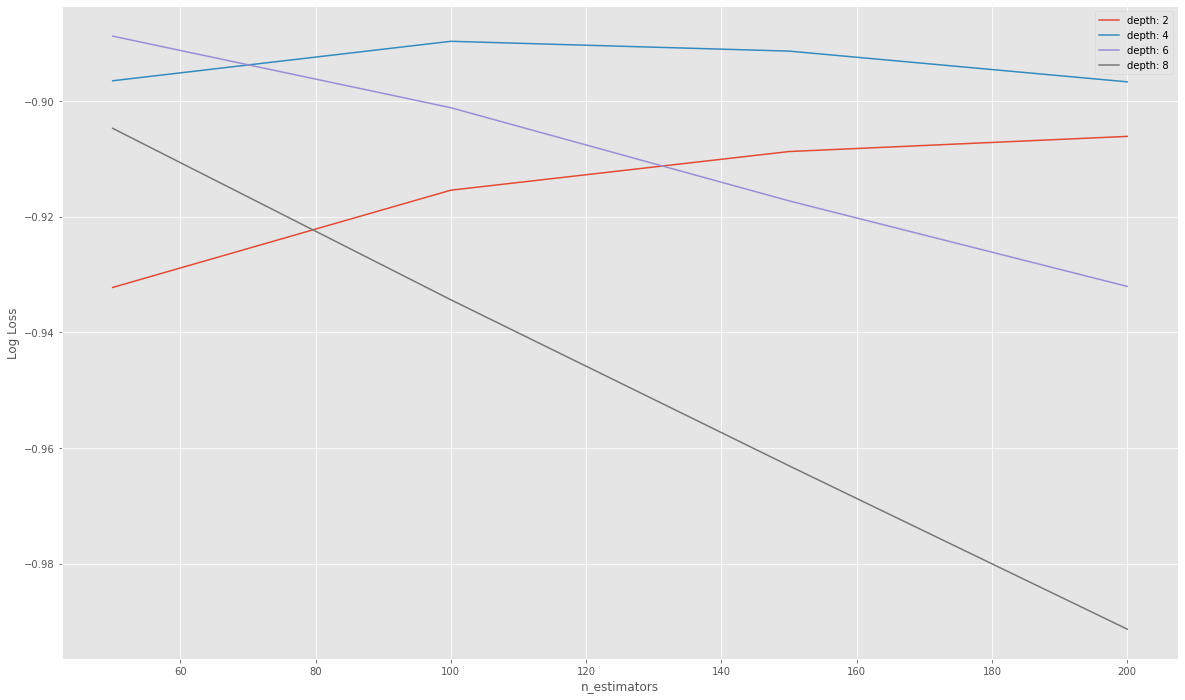

In [248]:
plt.figure(figsize=(20,12))
# summarize results
print("Best: %f using %s" % (xgb_results.best_score_, xgb_results.best_params_))
means = xgb_results.cv_results_['mean_test_score']
stds = xgb_results.cv_results_['std_test_score']
params = xgb_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

As we can see above, we had a very strong model but let's tune the hyperparameters once again to create even a more stronger model.

In [249]:
xgb = XGBClassifier()

param_grid = {'n_estimators':[35,40,50],'max_depth':[5,6,7]}

In [250]:
# fits a GridSearchCV classifier using refit_score for optimization
refit_score='precision_score'

# prints classifier performance metrics
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
xgb_grid = GridSearchCV(xgb, param_grid, scoring='neg_log_loss',
                           cv=skf, n_jobs=-1, verbose=1)


In [251]:
xgb_results = xgb_grid.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


Best: -0.888759 using {'max_depth': 5, 'n_estimators': 50}
-0.891876 (0.013411) with: {'max_depth': 5, 'n_estimators': 35}
-0.890329 (0.013553) with: {'max_depth': 5, 'n_estimators': 40}
-0.888759 (0.012722) with: {'max_depth': 5, 'n_estimators': 50}
-0.889110 (0.014206) with: {'max_depth': 6, 'n_estimators': 35}
-0.888916 (0.014055) with: {'max_depth': 6, 'n_estimators': 40}
-0.888760 (0.014790) with: {'max_depth': 6, 'n_estimators': 50}
-0.891305 (0.016721) with: {'max_depth': 7, 'n_estimators': 35}
-0.891915 (0.016888) with: {'max_depth': 7, 'n_estimators': 40}
-0.895125 (0.017422) with: {'max_depth': 7, 'n_estimators': 50}


Text(0, 0.5, 'Log Loss')

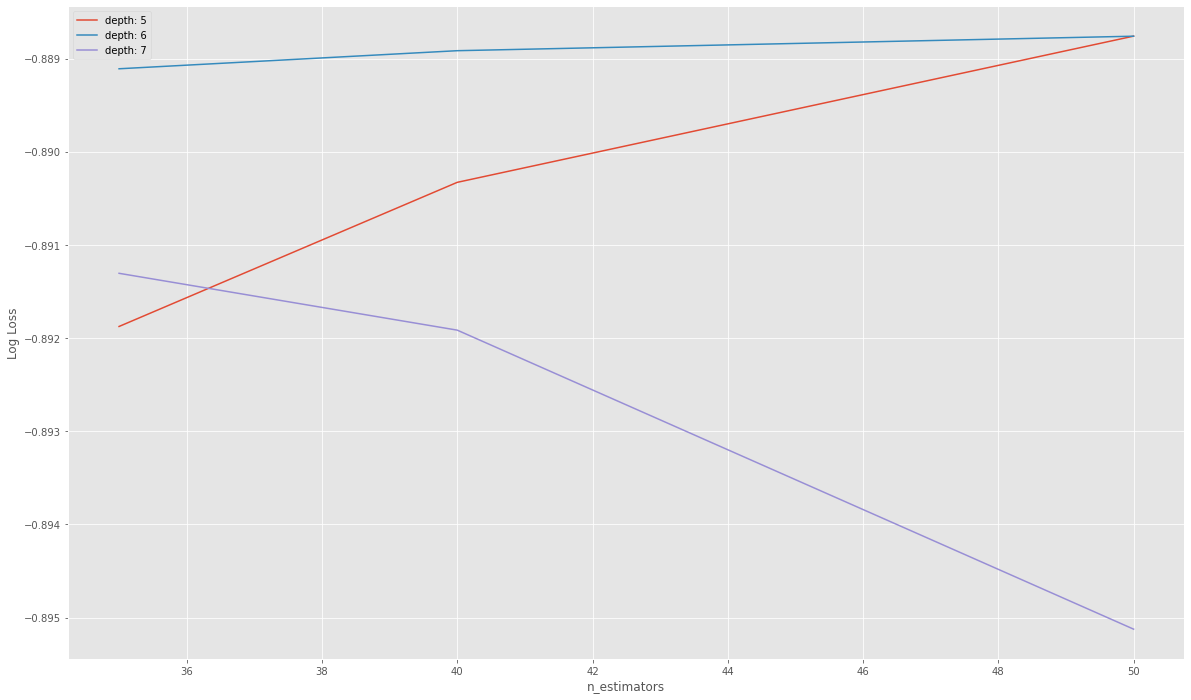

In [253]:
plt.figure(figsize=(20,12))
# summarize results
print("Best: %f using %s" % (xgb_results.best_score_, xgb_results.best_params_))
means = xgb_results.cv_results_['mean_test_score']
stds = xgb_results.cv_results_['std_test_score']
params = xgb_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
n_estimators = [35,40,50]
max_depth = [5,6,7]

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

In [254]:
xgb = XGBClassifier(max_depth=5, n_estimators=50).fit(X_train,y_train)

In [255]:
# make the predictions 
y_pred_xgb = xgb.predict(X_test)
y_pred_sep_xgb = xgb.predict(X_sep)

# calculate the probabilities 
y_prob_xgb = xgb.predict_proba(X_test)
y_prob_sep_xgb = xgb.predict_proba(X_sep)

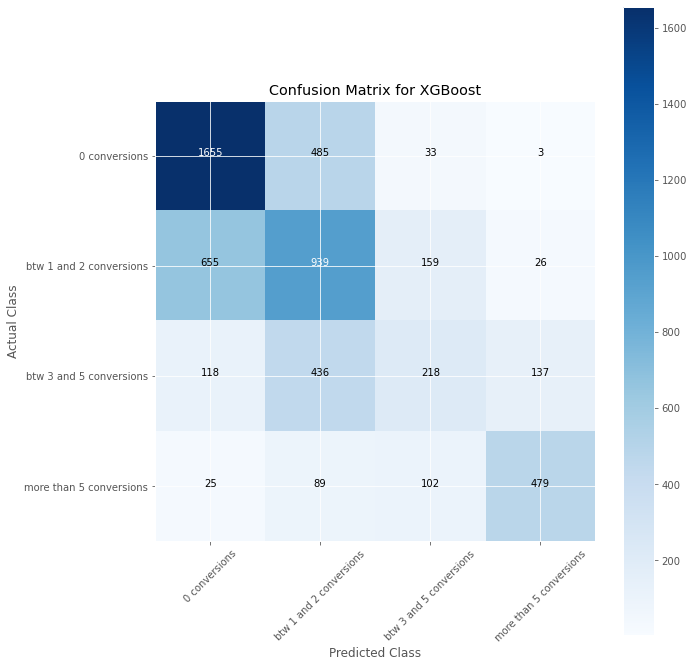

In [256]:
cnf_matrix = confusion_matrix(y_test, y_pred_xgb,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for XGBoost')

In [257]:
# Expending the dataframe with kNN:
# For Random Forest with Entropy:
y_test_df['pred_xgb'] = y_pred_xgb
y_test_df['prob_xgb']= np.round(np.array(y_prob_xgb),2).tolist()

y_test_sep_df['pred_xgb'] = y_pred_sep_xgb
y_test_sep_df['prob_xgb'] = np.round(np.array(y_prob_sep_xgb),2).tolist()

In [258]:
y_test_df.head(2)

,labels,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm,pred_xgb,prob_xgb
7890,more than 5 conversions,more than 5 conversions,"[0.0, 0.11, 0.32, 0.56]",more than 5 conversions,"[0.02, 0.04, 0.4, 0.54]",more than 5 conversions,"[0.02, 0.03, 0.41, 0.54]",more than 5 conversions,"[0.05, 0.1, 0.29, 0.57]",more than 5 conversions,"[0.01, 0.03, 0.18, 0.79]",more than 5 conversions,"[0.009999999776482582, 0.03999999910593033, 0...."
21440,0 conversions,0 conversions,"[0.79, 0.18, 0.03, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.93, 0.07, 0.0, 0.0]",0 conversions,"[0.86, 0.05, 0.1, 0.0]",0 conversions,"[0.78, 0.15, 0.06, 0.01]",0 conversions,"[0.8600000143051147, 0.11999999731779099, 0.00..."


In [269]:
y_test_sep_df.head(2)

,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm,pred_xgb,prob_xgb
0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.57, 0.38, 0.0, 0.05]",0 conversions,"[0.78, 0.18, 0.02, 0.01]",0 conversions,"[0.9700000286102295, 0.019999999552965164, 0.0..."
1,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.84, 0.14, 0.01, 0.01]",0 conversions,"[0.9900000095367432, 0.009999999776482582, 0.0..."


### AdaBoost

In [275]:
ada = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.001)

In [276]:
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.001)

In [277]:
# make the predictions for adaboost
y_pred_ada = ada.predict(X_test)
y_pred_sep_ada = ada.predict(X_sep)

# calculate the probabilities for adaboost
y_prob_ada = ada.predict_proba(X_test)
y_prob_sep_ada = ada.predict_proba(X_sep)

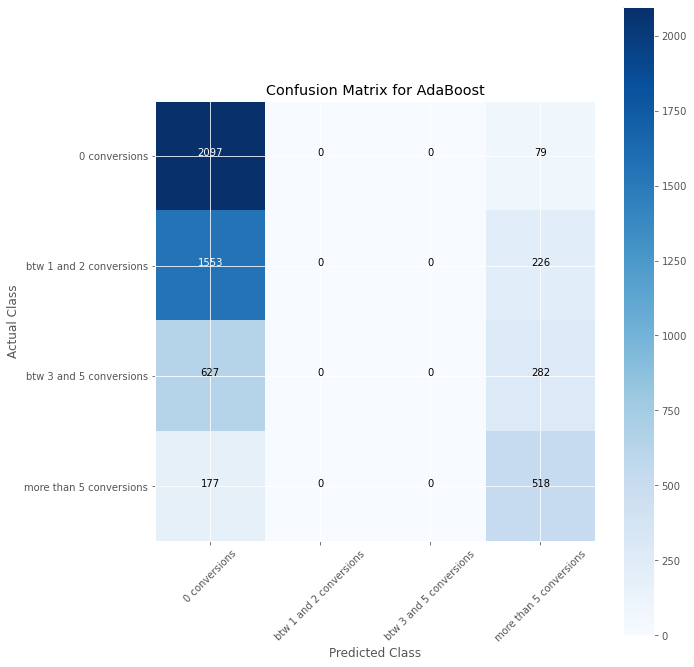

In [280]:
cnf_matrix = confusion_matrix(y_test, y_pred_ada,labels=label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=label,
                      title='Confusion Matrix for AdaBoost')

In [281]:
# Expending the dataframe with kNN:
# For Random Forest with Entropy:
y_test_df['pred_ada'] = y_pred_ada
y_test_df['prob_ada']= np.round(np.array(y_prob_ada),2).tolist()

y_test_sep_df['pred_ada'] = y_pred_sep_ada
y_test_sep_df['prob_ada'] = np.round(np.array(y_prob_sep_ada),2).tolist()

In [282]:
y_test_df.head(2)

,labels,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm,pred_xgb,prob_xgb,pred_ada,prob_ada
7890,more than 5 conversions,more than 5 conversions,"[0.0, 0.11, 0.32, 0.56]",more than 5 conversions,"[0.02, 0.04, 0.4, 0.54]",more than 5 conversions,"[0.02, 0.03, 0.41, 0.54]",more than 5 conversions,"[0.05, 0.1, 0.29, 0.57]",more than 5 conversions,"[0.01, 0.03, 0.18, 0.79]",more than 5 conversions,"[0.009999999776482582, 0.03999999910593033, 0....",more than 5 conversions,"[0.23, 0.23, 0.23, 0.32]"
21440,0 conversions,0 conversions,"[0.79, 0.18, 0.03, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.93, 0.07, 0.0, 0.0]",0 conversions,"[0.86, 0.05, 0.1, 0.0]",0 conversions,"[0.78, 0.15, 0.06, 0.01]",0 conversions,"[0.8600000143051147, 0.11999999731779099, 0.00...",0 conversions,"[0.32, 0.23, 0.23, 0.23]"


In [283]:
y_test_sep_df.head(2)

,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm,pred_xgb,prob_xgb,pred_ada,prob_ada
0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.57, 0.38, 0.0, 0.05]",0 conversions,"[0.78, 0.18, 0.02, 0.01]",0 conversions,"[0.9700000286102295, 0.019999999552965164, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]"
1,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.84, 0.14, 0.01, 0.01]",0 conversions,"[0.9900000095367432, 0.009999999776482582, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]"


After all the modeling, I will create the dataframe where I can take into account all the probabilities and combine them to make the final decision.

In [284]:
# create a new df to include the features
df_test = pd.merge(X_test,y_test_df,how = 'left',left_index = True, right_index = True)

In [285]:
df_test_sep = pd.merge(X_sep.reset_index(drop = True),y_test_sep_df,how = 'left',left_index = True, right_index = True)

Now let's do the opposite of standard scaling so that we can have the actual numbers. To do that we need to find out the mean and standard deviation.

To standardize the data:
$$
z=\frac{x-\mu}{\sigma}
$$

To reverse it:
$$
x=z*\sigma + \mu
$$

In [301]:
fb_std = df_sept.amount_spent_usd.std()
fb_mean = df_sept.amount_spent_usd.mean()

In [305]:
df_test_sep.amount_spent_usd = round(df_test_sep.amount_spent_usd*fb_std+fb_mean).astype(int)

In [306]:
prob_cols = [prob_col for prob_col in df_test_sep if prob_col.startswith('prob')]
df_probs = df_test_sep[prob_cols]
df_probs['probs_final'] = np.nan

In [307]:
df_probs.columns.tolist()

['prob_softmax',
 'prob_rf_gini',
 'prob_rf_enpy',
 'prob_knn',
 'prob_svm',
 'prob_xgb',
 'prob_ada',
 'probs_final']

In [308]:
prob_lst = []
for i in range(len(df_probs)):
    total_1 = 0
    total_2 = 0
    total_3 = 0
    total_4 = 0
    
    for j in range(len(df_probs.columns)-1):
        total_1 = total_1 + df_probs.iloc[i,j][0]
        total_2 = total_2 + df_probs.iloc[i,j][1]
        total_3 = total_3 + df_probs.iloc[i,j][2]
        total_4 = total_4 + df_probs.iloc[i,j][3]
        
    num_col = (len(df_probs.columns.tolist()) - 1)
    all_probs = [total_1, total_2, total_3, total_4]
    prob_lst.append([k/num_col for k in all_probs])

In [309]:
df_probs['probs_final'] = prob_lst

In [310]:
df_probs['pred_final'] = 0

In [311]:
df_test_sep['probs_final'] = prob_lst

In [312]:
some_ser = []
for i in range(len(df_probs)):
    some_lst = df_probs['probs_final'][i]
    m = max(some_lst)
    ind_max = some_lst.index(max(some_lst))
    some_ser.append(ind_max)

In [313]:
df_probs['pred_final'] = some_ser

In [314]:
df_probs.pred_final.value_counts()

0    196613
1     70533
2     40426
3     30348
Name: pred_final, dtype: int64

In [315]:
df_probs.pred_final = df_probs.pred_final.astype(int)
df_probs['final_prediction'] = np.nan

In [316]:
def label_converter(x):
    if x == 0:
        return '0 conversions'
    elif x == 1:
        return '1 or 2 conversions'
    elif x == 2:
        return 'btw 3 and 5 conversions'
    elif x == 3:
        return 'more than 5 conversions'
    else:
        return 'Error'

In [317]:
df_probs['final_prediction'] = df_probs['pred_final'].apply(label_converter)

In [319]:
df_predictions_sep = pd.merge(df_test_sep,df_probs[['final_prediction']],how = 'left',left_index = True, right_index = True)

In [321]:
df_predictions_sep

,month,week_num,DE,ES,FR,IT,MX,UK,US,ZA,OR,SSF,night,morning,afternoon,evening,Mon,Tues,Weds,Thurs,Fri,Sat,Sun,2018,2019,amount_spent_usd,pred_softmax,prob_softmax,pred_rf_gini,prob_rf_gini,pred_rf_enpy,prob_rf_enpy,pred_knn,prob_knn,pred_svm,prob_svm,pred_xgb,prob_xgb,pred_ada,prob_ada,probs_final,final_prediction
0,9,35,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0 conversions,"[0.97, 0.02, 0.0, 0.0]",0 conversions,"[0.92, 0.08, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.57, 0.38, 0.0, 0.05]",0 conversions,"[0.78, 0.18, 0.02, 0.01]",0 conversions,"[0.9700000286102295, 0.019999999552965164, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]","[0.7828571469443185, 0.137142857078995, 0.0357...",0 conversions
1,9,35,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.95, 0.05, 0.0, 0.0]",0 conversions,"[0.84, 0.14, 0.01, 0.01]",0 conversions,"[0.9900000095367432, 0.009999999776482582, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]","[0.8657142870766776, 0.06714285711092609, 0.03...",0 conversions
2,9,35,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.97, 0.03, 0.0, 0.0]",0 conversions,"[0.81, 0.19, 0.0, 0.0]",0 conversions,"[0.89, 0.1, 0.01, 0.0]",0 conversions,"[0.9900000095367432, 0.009999999776482582, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]","[0.8485714299338205, 0.08571428568235465, 0.03...",0 conversions
3,9,35,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.76, 0.24, 0.0, 0.0]",0 conversions,"[0.9, 0.09, 0.01, 0.0]",0 conversions,"[0.9900000095367432, 0.009999999776482582, 0.0...",0 conversions,"[0.32, 0.23, 0.23, 0.23]","[0.8471428585052491, 0.08714285711092608, 0.03...",0 conversions
4,9,35,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.99, 0.01, 0.0, 0.0]",0 conversions,"[0.98, 0.02, 0.0, 0.0]",0 conversions,"[0.86, 0.14, 0.0, 0.0]",0 conversions,"[0.89, 0.09, 0.01, 0.01]",0 conversions,"[0.9900000095367432, 0.0, 0.0, 0.0]",0 conversions,"[0.32, 0.23, 0.23, 0.23]","[0.860000001362392, 0.07142857142857142, 0.034...",0 conversions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337915,9,40,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,350,btw 1 and 2 conversions,"[0.02, 0.58, 0.31, 0.1]",btw 3 and 5 conversions,"[0.17, 0.26, 0.44, 0.13]",btw 3 and 5 conversions,"[0.16, 0.28, 0.42, 0.15]",more than 5 conversions,"[0.0, 0.1, 0.38, 0.52]",more than 5 conversions,"[0.13, 0.13, 0.28, 0.47]",btw 1 and 2 conversions,"[0.25, 0.49000000953674316, 0.2300000041723251...",more than 5 conversions,"[0.23, 0.23, 0.23, 0.32]","[0.13714285714285715, 0.29571428707667763, 0.3...",btw 3 and 5 conversions
337916,9,40,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,350,more than 5 conversions,"[0.0, 0.12, 0.19, 0.69]",btw 1 and 2 conversions,"[0.13, 0.32, 0.28, 0.27]",btw 1 and 2 conversions,"[0.16, 0.31, 0.25, 0.28]",more than 5 conversions,"[0.14, 0.19, 0.29, 0.38]",btw 3 and 5 conversions,"[0.2, 0.23, 0.29, 0.28]",btw 1 and 2 conversions,"[0.14000000059604645, 0.3700000047683716, 0.36...",more than 5 conversions,"[0.23, 0.23, 0.23, 0.32]","[0.14285714294229238, 0.25285714353833877, 0.2...",more than 5 conversions
337917,9,40,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,350,more than 5 conversions,"[0.01, 0.23, 0.23, 0.54]",btw 3 and 5 conversions,"[0.19, 0.32, 0.34, 0.16]",btw 1 and 2 conversions,"[0.19, 0.31, 0.3, 0.2]",more than 5 conversions,"[0.0, 0.1, 0.38, 0.52]",more than 5 conversions,"[0.11, 0.12, 0.28, 0.49]",btw 1 and 2 conversions,"[0.2199999988079071, 0.4600000

In [324]:
df_predictions_sep.final_prediction.value_counts()

0 conversions              196613
1 or 2 conversions          70533
btw 3 and 5 conversions     40426
more than 5 conversions     30348
Name: final_prediction, dtype: int64

In [ ]:
df_predictions_sep.to_csv('./data/sep_pred.csv',index=False)